In [102]:
import pandas as pd
data=pd.read_csv('../raw_data/Tool_Info.csv')
data['age']=2019-data['year_of_pub']+1
data['citation_per_year']=data['num_citations']/data['age']
data.loc[data.loc[:,'aligner'] == 'HISAT2', 'citation_per_year'] = 95

# Creating new columns that combine rarer types
data.loc[data.loc[:,'indexing'] == 'hashing', 'index'] = 'Hashing'
data.loc[data.loc[:,'indexing'] == 'BWT-FM', 'index'] = 'BWT-FM'
data.loc[data.loc[:,'indexing'] == 'BWT-FM + hashing', 'index'] = 'BWT-FM & Hashing'
data.loc[data.loc[:,'indexing'] == 'suffix array', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT-ST', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'suffix tree', 'index'] = 'Other Suffix'

data.loc[data.loc[:,'pairwise_alignment'] == 'SW', 'pairwise'] = 'Smith-Waterman'
data.loc[data.loc[:,'pairwise_alignment'] == 'HD', 'pairwise'] = 'Hamming Distance'
data.loc[data.loc[:,'pairwise_alignment'] == 'NW', 'pairwise'] = 'Needleman-Wunsch'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP Heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'Rabin-Karp Algorithm', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Landau-Vishkin', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Sparse DP', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Banded Myers Bit Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Myers Bit-Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-Global', 'pairwise'] = 'Other DP'

data.loc[data.loc[:, 'wrapper'] == 'Y', 'wrap'] = 'Yes'
data.loc[data.loc[:, 'wrapper'] == 'N', 'wrap'] = 'No'

data.loc[data.loc[:,'fix_length_seed'] == 'Y', 'seeds_fixed'] = 'Yes'
data.loc[data.loc[:,'fix_length_seed'] == 'N', 'seeds_fixed'] = 'No'

data.loc[data.loc[:,'seed_chaining'] == 'Y', 'seeds_chained'] = 'Yes'
data.loc[data.loc[:,'seed_chaining'] == 'N', 'seeds_chained'] = 'No'

data.loc[data.loc[:,'spaced_seed'] == 'Y', 'seeds_spaced'] = 'Yes'
data.loc[data.loc[:,'spaced_seed'] == 'N', 'seeds_spaced'] = 'No'

data_year = pd.DataFrame(data.loc[:,['year_of_pub', 'aligner', 'application', 'index', 'pairwise', 
                              'seeds_fixed', 'seeds_spaced', 'seeds_chained', 'wrap', 'wrapper_of']])

data_year.head()

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of
0,2019,BatMeth2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,No,NaN
1,2013,BS-Seeker2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2
2,2012,BRAT-BW,BS-Seq,BWT-FM,Hamming Distance,No,No,No,No,NaN
3,2011,Bismark,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2 or HISAT2
4,2010,BS-Seeker,BS-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie


In [103]:
idx_rt = pd.read_csv('../raw_data/compare.tools.index.csv')

data_year.loc[:,'aligner_lower'] = data_year.loc[:,'aligner'].str.lower()
idx_rt.loc[:,'tools_lower'] = idx_rt.loc[:,'Tools'].str.lower()

rtidx = pd.merge(idx_rt, data_year, left_on='tools_lower', 
                 right_on='aligner_lower', how='inner').loc[:,['aligner', 'application', 'year_of_pub',
                                                               'Runtime','Virtual Mem (G)', 'index']]
rtidx = rtidx.loc[rtidx.loc[:,'application'].str.contains('DNA'),:]
rtidx = rtidx.loc[rtidx.loc[:,'aligner'] != 'MOSAIK']
rtidx = rtidx.dropna().reset_index(drop=True)
t = pd.DatetimeIndex(rtidx.loc[:,'Runtime'])
rtidx.loc[:,'Runtime (hours)'] = (t.hour*60 + t.minute)/60
rtidx

,aligner,application,year_of_pub,Runtime,Virtual Mem (G),index,Runtime (hours)
0,Bowtie2,DNA,2012,1:53:39,5.398,BWT-FM,1.883333
1,Bowtie,DNA,2009,1:42:21,5.395,BWT-FM,1.700000
2,BWA,DNA,2009,1:10:43,4.448,BWT-FM,1.166667
3,GSNAP,DNA,2010,1:08:32,19.561,Hashing,1.133333
4,HISAT2,DNA,2019,1:07:14,5.394,BWT-FM,1.116667
5,LAST,DNA/BS-Seq/protein/RNA,2011,0:55:16,28.148,Other Suffix,0.916667
6,segemehl,DNA,2009,1:26:45,57.773,Other Suffix,1.433333
7,SMALT,DNA,2010,0:01:58,6.668,Hashing,0.016667
8,SNAP,DNA,2011,4:04:26,39.313,Hashing,4.066667
9,Subread,DNA/RNA-Seq,2013,0:18:53,6.853,Hashing,0.300000


In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scp
import numpy as np

tool_clrs = ['teal', 'palegreen', 'purple', 'deepskyblue', 'magenta', 'maroon', 
        'darkorange', 'limegreen', 'turquoise', 'blue']

index_clrs = ['darkorange', 'mediumorchid', 'cornflowerblue', 'navy']

local_clrs = ['orange', 'deepskyblue', 'chocolate', 'gold', 'royalblue', 'lightseagreen']

order_by_year = ["segemehl", "Bowtie", "BWA", "GSNAP", "SMALT", "LAST", "SNAP", "Bowtie2", "Subread", "HISAT2"]

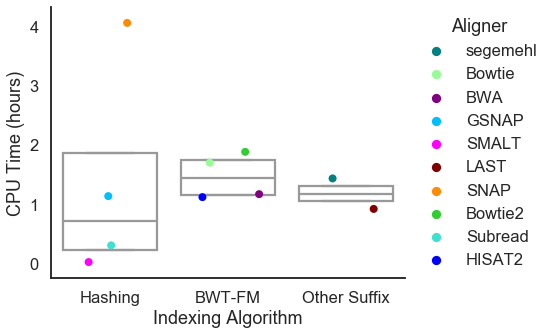

In [105]:
plt.figure(figsize=(8,5))

sns.set_style('white')
sns.set_context('talk')
ax = sns.boxplot(data = rtidx, x = 'index', y = 'Runtime (hours)', whis=0,
                 order = ['Hashing', 'BWT-FM', 'Other Suffix'], color="1", fliersize = 0)
ax = sns.stripplot(data= rtidx, x = 'index', y = 'Runtime (hours)', order=['Hashing','BWT-FM','Other Suffix'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3)
ax.set(xlabel = 'Indexing Algorithm', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
sns.despine()

plt.savefig('../figures/FigureS1_a.png')
plt.savefig('../figures/FigureS1_a.pdf')

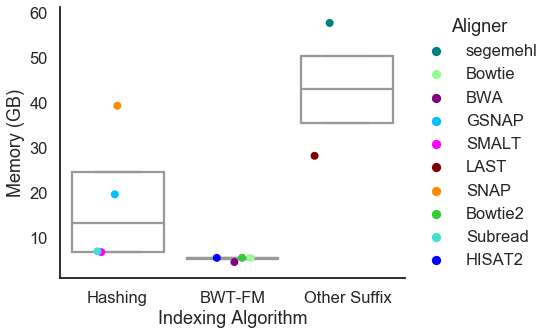

In [106]:
plt.figure(figsize=(8,5))

sns.set_style('white')
sns.set_context('talk')
ax = sns.boxplot(data = rtidx, x = 'index', y = 'Virtual Mem (G)', whis=0,
                 order = ['Hashing', 'BWT-FM', 'Other Suffix'], color="1", fliersize = 0)
ax = sns.stripplot(data= rtidx, x = 'index', y = 'Virtual Mem (G)', order=['Hashing','BWT-FM','Other Suffix'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3)
ax.set(xlabel = 'Indexing Algorithm', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
sns.despine()

plt.savefig('../figures/FigureS1_b.png')
plt.savefig('../figures/FigureS1_b.pdf')

In [131]:
rna_tools = pd.DataFrame(data_year.loc[data_year.application.str.contains('RNA'),:])
rna_tools

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,aligner_lower
78,2011,LAST,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods,No,Yes,No,No,NaN,last
81,2019,Magic-BLAST,DNA/RNA-Seq,Hashing,Non-DP Heuristic,Yes,No,No,No,NaN,magic-blast
82,2019,GraphMap2,DNA/RNA-Seq,Hashing,Other DP,Yes,Yes,Yes,No,NaN,graphmap2
83,2018,minimap2,DNA/RNA-Seq,Hashing,Needleman-Wunsch,Yes,No,Yes,No,NaN,minimap2
84,2013,Subread,DNA/RNA-Seq,Hashing,Smith-Waterman,Yes,Yes,Yes,No,NaN,subread
85,1988,FASTA,DNA/RNA-Seq,Hashing,Multiple Methods,Yes,No,Yes,No,NaN,fasta
86,2019,deSALT,RNA-seq,Hashing,Smith-Waterman,Yes,No,Yes,No,NaN,desalt
87,2017,DART,RNA-Seq,BWT-FM,Needleman-Wunsch,No,No,Yes,No,NaN,dart
88,2015,ContextMap 2,RNA-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,"Bowtie, Bowtie2, or BWA",contextmap 2
89,2015,HISAT,RNA-Seq,BWT-FM,Non-DP Heuristic,Yes,No,No,No,NaN,hisat


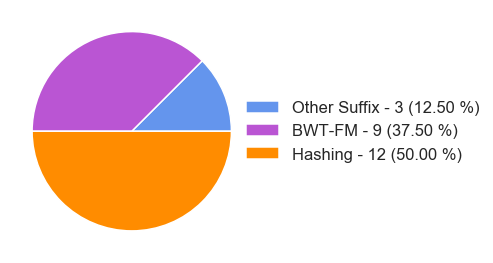

In [107]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')

idx_group = rna_tools.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[2::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()

plt.savefig('../figures/FigureS2_0.png')
plt.savefig('../figures/FigureS2_0.pdf')

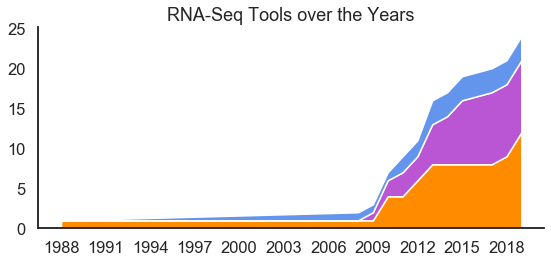

In [108]:
plt.figure(figsize=(8,4))

by_year = rna_tools.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index
by_year

sns.set_style('white')
sns.set_context('talk')
plt.stackplot(x, by_year.loc[:,'Hashing'], by_year.loc[:,'BWT-FM'], by_year.loc[:,'Other Suffix'], 
              labels=['Hashing','BWT-FM','Other Suffix'], colors=index_clrs)
#plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.xticks(range(min(x), max(x)+1, 3))
plt.title('RNA-Seq Tools over the Years')
#plt.show()
sns.despine()

plt.tight_layout()
plt.savefig('../figures/FigureS2_1.png')
plt.savefig('../figures/FigureS2_1.pdf')

In [125]:
rna_wrappers = rna_tools[rna_tools.wrap == 'Yes']
rna_nonwrappers = rna_tools[rna_tools.wrap == 'No']

rna_wrappers

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,aligner_lower
88,2015,ContextMap 2,RNA-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,"Bowtie, Bowtie2, or BWA",contextmap 2
90,2014,JAGuaR,RNA-Seq,BWT-FM,Smith-Waterman,Yes,No,No,Yes,BWA,jaguar
93,2013,TopHat2,RNA-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2,tophat2
96,2012,Passion,RNA-Seq,Hashing,Smith-Waterman,Yes,No,Yes,Yes,SMALT,passion
98,2010,MapSplice,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,mapsplice
100,2010,SpliceMap,RNA-Seq,Hashing,Hamming Distance,Yes,No,No,Yes,Bowtie,splicemap
102,2009,TopHat,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,tophat
103,2008,QPALMA,RNA-Seq,Other Suffix,Smith-Waterman,Yes,No,Yes,Yes,vmatch,qpalma


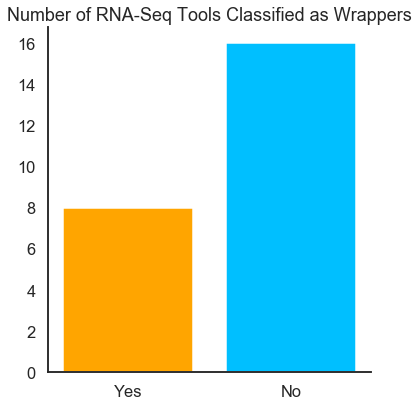

In [126]:
plt.figure(figsize=(6,6))

sns.set_style('white')
sns.set_context('talk')
idx_group = rna_tools.groupby('wrap').count().sort_values('aligner', ascending=True)
ax = plt.bar(idx_group.index, idx_group.aligner, color=local_clrs[:2])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()

plt.title("Number of RNA-Seq Tools Classified as Wrappers")
#plt.show()

sns.despine()
plt.tight_layout()
plt.savefig('../figures/FigureS3_0.png')
plt.savefig('../figures/FigureS3_0.pdf')

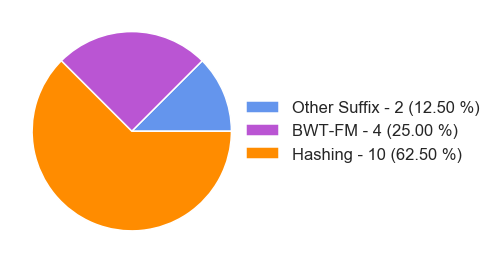

In [127]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')
idx_group = rna_nonwrappers.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[2::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()
plt.savefig('../figures/FigureS4_0.png')
plt.savefig('../figures/FigureS4_0.pdf')

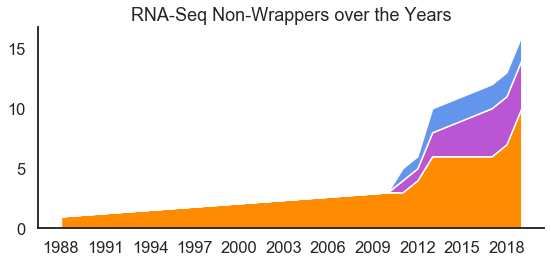

In [128]:
plt.figure(figsize=(8,4))

sns.set_style('white')
sns.set_context('talk')
by_year = rna_nonwrappers.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index
by_year

plt.stackplot(x, by_year.loc[:,'Hashing'], by_year.loc[:,'BWT-FM'], by_year.loc[:,'Other Suffix'], 
              labels=['Hashing','BWT-FM','Other Suffix'], colors=index_clrs)
#plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.xticks(range(min(x), max(x)+1, 3))
plt.title('RNA-Seq Non-Wrappers over the Years')
#plt.show()
sns.despine()
plt.tight_layout()
plt.savefig('../figures/FigureS4_1.png')
plt.savefig('../figures/FigureS4_1.pdf')

In [130]:
bs_tools = pd.DataFrame(data_year.loc[data_year.application.str.contains('BS'),:])
bs_tools

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,aligner_lower
0,2019,BatMeth2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,No,NaN,batmeth2
1,2013,BS-Seeker2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2,bs-seeker2
2,2012,BRAT-BW,BS-Seq,BWT-FM,Hamming Distance,No,No,No,No,NaN,brat-bw
3,2011,Bismark,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2 or HISAT2,bismark
4,2010,BS-Seeker,BS-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,bs-seeker
5,2009,BRAT,BS-Seq,Hashing,Hamming Distance,Yes,No,No,No,NaN,brat
6,2009,BSMAP,BS-Seq,Hashing,Hamming Distance,Yes,No,No,No,NaN,bsmap
77,2016,ERNE 2,DNA/BS-Seq,BWT-FM & Hashing,Hamming Distance,Yes,No,No,No,NaN,erne 2
78,2011,LAST,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods,No,Yes,No,No,NaN,last


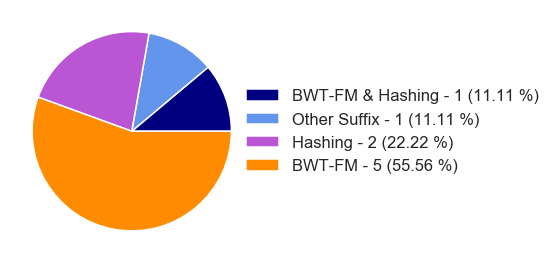

In [133]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')

idx_group = bs_tools.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()

plt.savefig('../figures/FigureS5_0.png')
plt.savefig('../figures/FigureS5_0.pdf')

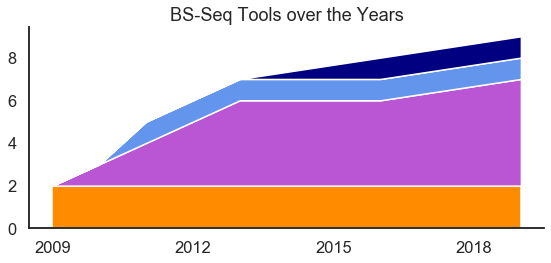

In [134]:
plt.figure(figsize=(8,4))

by_year = bs_tools.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index
by_year

sns.set_style('white')
sns.set_context('talk')
plt.stackplot(x, by_year.loc[:,'Hashing'], by_year.loc[:,'BWT-FM'], by_year.loc[:,'Other Suffix'], 
              by_year.loc[:,'BWT-FM & Hashing'], labels=['Hashing','BWT-FM','Other Suffix','BWT-FM & Hashing'], 
              colors=index_clrs)
#plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.xticks(range(min(x), max(x)+1, 3))
plt.title('BS-Seq Tools over the Years')
#plt.show()
sns.despine()

plt.tight_layout()
plt.savefig('../figures/FigureS5_1.png')
plt.savefig('../figures/FigureS5_1.pdf')

In [135]:
bs_wrappers = bs_tools[bs_tools.wrap == 'Yes']
bs_nonwrappers = bs_tools[bs_tools.wrap == 'No']

bs_wrappers

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,aligner_lower
1,2013,BS-Seeker2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2,bs-seeker2
3,2011,Bismark,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2 or HISAT2,bismark
4,2010,BS-Seeker,BS-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,bs-seeker


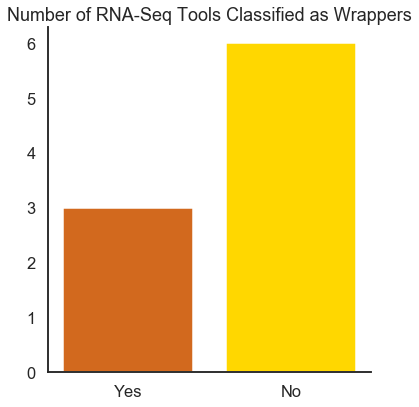

In [136]:
plt.figure(figsize=(6,6))

sns.set_style('white')
sns.set_context('talk')
idx_group = bs_tools.groupby('wrap').count().sort_values('aligner', ascending=True)
ax = plt.bar(idx_group.index, idx_group.aligner, color=local_clrs[2:4])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()

plt.title("Number of RNA-Seq Tools Classified as Wrappers")
#plt.show()

sns.despine()
plt.tight_layout()
plt.savefig('../figures/FigureS6_0.png')
plt.savefig('../figures/FigureS6_0.pdf')

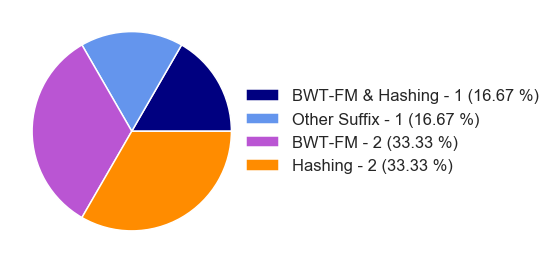

In [137]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')
idx_group = bs_nonwrappers.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()
plt.savefig('../figures/FigureS7_0.png')
plt.savefig('../figures/FigureS7_0.pdf')